WILMINGTON

SUMMARY:
These models, both before and after community partner recommendations, were originally three-stage: 
First, constrained by budget, a model is run to figure out the maximum proportion of the population that could be served by hubs. This number is multiplied by a scale factor less than 1, which is set before the model is run, to determine the amount of demand to be satisfied in later models.

Second, constrained by this scaled demand and the budget, a model is run to figure out the minimum aggregate distance that people must travel to reach hubs. This number is multiplied by a scale factor greater than 1, which is set before the model is run, to determine the maximum aggregate distance people can travel in later models. 

Finally, constrained by the demand from model 1 and the aggregate distance from model 2, a model is run to minimize the cost of built hubs.

However, the models returned very different results depending on the choice of scaling factors, and they were also hard to compare to one another because the proportion of California’s population that could be seen by the models depends strongly on whether there is a maximum distance people can travel imposed. When a maximum of one mile walking distance is imposed, for example, many block groups in Contra Costa aren’t near enough to any potential hubs, so people in them aren’t taken into account. Seemingly because of this, and because of general differences between walking and driving matrices (this difference was observed even when there was no maximum walking distance imposed), walking models consistently spent less of the budget than driving models, because they had to serve fewer people. 

Because of this, this notebook runs these models:
Constraints:
Budget (can’t spend more than budget)
A person can't travel more than some maximum travel distance (1 mile, 3 miles, no maximum...)

Objective functions:
Maximize number of people served by hubs
    Walkability: Rescale distance matrix based on walkability of hub
    CES: Rescale how many people one person counts as based on their block group’s CES score

What we’re wanting to do in these models is to maximize number of people served, minimize distance traveled, subject to a budget constraint. But actually it doesn’t matter what distance they travel if we cap how far they can go in the distance matrix as being under 1 mile, under 3 miles, etc. So really, we can use an edited distance matrix, a budget constraint, and maximize number people served. This also gives us a better way to incorporate walkability and CES scores – we can scale distance by reverse walkability score before editing the distance matrix down, so for higher scoring block groups all distances seem less (so they could be included in the distance matrix even if their distance is technically over 1 mile, over 3 miles, etc). We can also scale people by their CES scores, so it looks like a person is 1 person if they're in a 100% CES percentile block group and it looks like they’re 0 people if they're in a 0% CES percentile block group. This ensures that, even though we’re ending up seeing different numbers of people as capable of going to a hub (with different max. distances for driving vs walking), we ultimately are solving the same problem with the same constraints, which makes the models comparable. We just can’t compare the objective function optimal values across CES vs non-CES models, but we could still compare the demographics of people ultimately served in CES vs non CES models.

In this notebook, I run the described model as a driving model, walking, walkability, walkability + CES, and rescaled walking population for Contra Costa county. I compare characteristics of recommended hubs including hub locations, hub type, hub count, and hub capacity.

In [135]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
from pyomo.environ import *
import pyomo.opt as pyopt

import geopandas as gpd
import pandas as pd
import numpy as np
from statistics import mean

import itertools

import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import shapely
import folium
import plotly.graph_objects as go # or plotly.express as px
import seaborn as sns

import solve_models_functions_cmm 
from solve_models_functions_cmm import *

import data_cleaning_cmm
from data_cleaning_cmm import (blockgroup_pop_dict, blockgroup_walkability_dict, blockgroup_no_car_pop_dict, bg_ces_dict,
                               survey_distance_dict,
                               dist_to_site_wilmington_df, dist_to_site_wilmington_dict,
                               dist_to_site_wilmington_walk_df, dist_to_site_wilmington_walk_dict,
                           county_prop_ealp_dict, site_kw_occ_dict,
                           site_sqft_dict, site_cost_dict)

import locate_site_bgs_cmm
from locate_site_bgs_cmm import (sites_bgs_dict)

In [142]:
import importlib
importlib.reload(data_cleaning_cmm)
# Base model
import deployment_models_cmm

importlib.reload(deployment_models_cmm)
importlib.reload(solve_models_functions_cmm)


<module 'solve_models_functions_cmm' from '/Users/clairemorton/Documents/__PSE/sgc-deployment-scenarios/solve_models_functions_cmm.py'>

In [143]:
importlib.reload(locate_site_bgs_cmm)
from locate_site_bgs_cmm import (sites_bgs_dict)

In [144]:
# Load sites data
ca_albers_nad83 = 'NAD_1983_California_Teale_Albers_FtUS'
nad83 = 'EPSG:4269'
wgs84 = 'EPSG:4326'

# Building candidate sites GeoDataFrame
sites_path = os.path.join(os.getcwd(), 'data', 'candidate_site_campuses_2021-11-17', 'candidate_sites_campuses.csv')
sites_df_raw = pd.read_csv(sites_path)
sites_df_raw = sites_df_raw.loc[sites_df_raw['cat_site'] != 'X', ['id_site', 'type_site', 'cat_site', 'SQFT_ROOF', 'LON', 'LAT']]
sites_geom = gpd.points_from_xy(sites_df_raw.LON, sites_df_raw.LAT, crs = nad83)
sites_gdf = gpd.GeoDataFrame(sites_df_raw, geometry = sites_geom, crs = nad83)

In [139]:
# match sites to the walkability fo the block groups they're in
for site, bg in sites_bgs_dict.items():
    sites_bgs_dict[site] = blockgroup_walkability_dict.get(bg)

In [140]:
# change the church near Tzu Chi clinic and the Senior center to have 0 cost
site_cost_dict['407808844'] = 0 # senior center
site_cost_dict['407808722'] = 0 # Tzu Chi church

In [145]:
# Run models
# apply cost minimization combined function

max_cost = 5000000 # $ that we can spend on hubs
max_distance_walk = 1
max_distance_drive = 3
to_build = ['407808844', '407808722']
#dist_to_site_wilmington_df
w_drive = model_pop_served_max(dist_to_site_wilmington_df.copy(), max_cost, max_distance_drive, to_build)
w_walk = model_pop_served_max(dist_to_site_wilmington_walk_df.copy(), max_cost, max_distance_walk, to_build)
w_walk_survey = model_pop_served_max_survey(dist_to_site_wilmington_walk_df.copy(), max_cost, to_build)
#w_walk_pop = model_pop_served_max(dist_to_site_wilmington_walk_df.copy(), max_cost, max_distance_walk, walk_pop = True)
#w_walk_ces = model_pop_served_max(dist_to_site_wilmington_walk_df.copy(), max_cost, max_distance_walk, CES = True)
#w_walkability = model_pop_served_max(scale_walkability(sites_bgs_dict.copy(), dist_to_site_wilmington_walk_df.copy()), 
#                                                           max_cost, max_distance_walk, CES = False)
#w_walkability_ces = model_pop_served_max(scale_walkability(sites_bgs_dict.copy(), dist_to_site_wilmington_walk_df.copy()), 
#                                                           max_cost, max_distance_walk, CES = True)
#w_walkability_ces_walk_pop = model_pop_served_max(scale_walkability(sites_bgs_dict.copy(), dist_to_site_wilmington_walk_df.copy()), 
#                                                           max_cost, max_distance_walk, CES = True, walk_pop = True)
#w_ces_walk_pop = model_pop_served_max(dist_to_site_wilmington_df.copy(), 
#                                                           max_cost, max_distance_walk, CES = True, walk_pop = True)
#w_walkability_walk_pop = model_pop_served_max(scale_walkability(sites_bgs_dict.copy(), dist_to_site_wilmington_walk_df.copy()), 
#                                                           max_cost, max_distance_walk, CES = False, walk_pop = True)


ValueError: Unable to coerce to Series, length must be 12: given 2

In [133]:
w_walk

,BUILT,CAPACITY
407808722,1,3846.487414
407808844,1,6914.285482
70330888,0,121843.945859
407809112,0,7256.099771
797745383,0,69189.156881
797744802,0,28440.773272
800655210,0,29393.534802
796874745,1,12621.316465
797207163,0,28189.482002
407624485,1,9412.228333


In [134]:
w_drive

,BUILT,CAPACITY
407808722,1,3846.487414
407808844,1,6914.285482
407809112,0,7256.099771
70330888,0,121843.945859
796874745,1,12621.316465
796874756,0,22787.096592
797207163,0,28189.482002
797744802,0,28440.773272
797745383,0,69189.156881
800655210,0,29393.534802


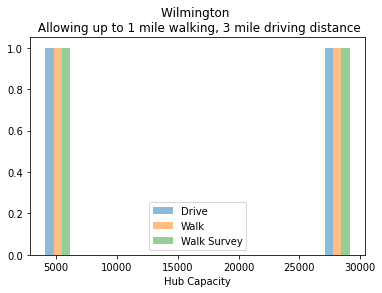

In [114]:
plot_capacity([w_drive, w_walk, w_walk_survey],
              ["Drive", "Walk", "Walk Survey"],
             "Wilmington \n Allowing up to 1 mile walking, 3 mile driving distance")

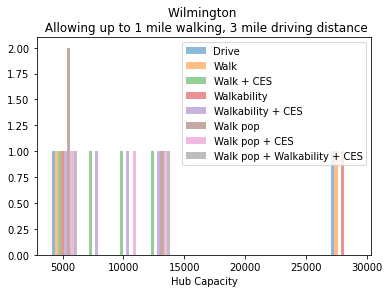

In [66]:
plot_capacity([w_drive, w_walk, 
               w_walk_ces, w_walkability,
               w_walkability_ces, w_walk_pop,
               w_ces_walk_pop,
               w_walkability_ces_walk_pop],
              ["Drive", "Walk", 
               "Walk + CES", "Walkability", 
               "Walkability + CES", "Walk pop", 
               "Walk pop + CES",
               "Walk pop + Walkability + CES"],
             "Wilmington \n Allowing up to 1 mile walking, 3 mile driving distance")

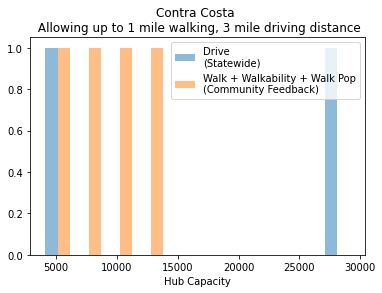

In [63]:
plot_capacity([w_drive, 
              w_walkability_walk_pop],
              ["Drive\n(Statewide)", 
                "Walk + Walkability + Walk Pop\n(Community Feedback)"],
             "Contra Costa \n Allowing up to 1 mile walking, 3 mile driving distance")

From these plots, it looks like generally:

    -Walking models recommend similar hubs to driving models (community center only)
    
    -Adding walkability to models (prioritizing hubs in areas that are more walkable) yields similar results
    
    -Adding CES ranking to models doesn't prioritize smaller hubs
   
    -Adding in the population of people who we assume are walking to models dramatically prioritizes building many smaller hubs

In [115]:
map_hubs(w_walk, sites_gdf)

In [58]:
map_hubs(w_walk_pop, sites_gdf)

These maps show that, even without a distance between built hubs constraint, the models that incorporate the amount of the population that we estimate is walking do the best job of spreading out hubs.

In [13]:
type_dist([var_hub_yn_contra_costa_drive, var_hub_yn_contra_costa_walk, 
               var_hub_yn_contra_costa_walk_ces, var_hub_yn_contra_costa_walkability,
               var_hub_yn_contra_costa_walkability_ces, var_hub_yn_contra_costa_walk_pop,
               var_hub_yn_contra_costa_ces_walk_pop,
               var_hub_yn_contra_costa_walkability_ces_walk_pop,
               var_hub_yn_contra_costa_walk_cf,
               var_hub_yn_contra_costa_walkability_walk_pop_cf],
              ["Drive", "Walk", 
               "Walk + CES", "Walkability", 
               "Walkability + CES", "Walk pop", 
               "Walk pop + CES",
               "Walk pop + Walkability + CES", 
               "Walk + CF",
               "Walk + Walkability + Walk Pop + CF"],
          sites_gdf)


 Drive
CC    0.5
W     0.5
Name: cat_site, dtype: float64

 Walk
Pri    0.5
W      0.5
Name: cat_site, dtype: float64

 Walk + CES
W      0.6
Sec    0.2
CC     0.2
Name: cat_site, dtype: float64

 Walkability
CC    0.5
W     0.5
Name: cat_site, dtype: float64

 Walkability + CES
W     0.75
CC    0.25
Name: cat_site, dtype: float64

 Walk pop
W     0.833333
CC    0.166667
Name: cat_site, dtype: float64

 Walk pop + CES
W     0.8
CC    0.2
Name: cat_site, dtype: float64

 Walk pop + Walkability + CES
W     0.9
CC    0.1
Name: cat_site, dtype: float64

 Walk + CF
Pri    0.5
W      0.5
Name: cat_site, dtype: float64

 Walk + Walkability + Walk Pop + CF
W     0.909091
CC    0.090909
Name: cat_site, dtype: float64
